## Introduction
This is a basically a generic “template” of Jupyter script that shows how to play with Chris' `secondlayer` library.

**To-do list**:

* Functionalize more the plotting part:
    - go up to OOP? (This way, one could get a constructor and update routines rather easily for the user. But beware that it may make less transparent changing tick locators & Co :/);
    - allow plotting the evolution or at least a initial/final comparison.
* Implement some additional `load_*` custom wrappers (at least one for MNIST?).
* Fix the bias typo in `gdummy*` functions (wait for Chris' solution).

In [1]:
# If using Python 2.7, please perform the following import.
# Otherwise Python 3.6+ is assumed to be used ;).
#from __future__ import (division, print_function, unicode_literals,
#                        absolute_import)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

#from secondlayer import gdummyv
from secondlayer import gdummynv
#from secondlayer import gdummynvana
from secondlayer import compute_error_v
from secondlayer import compute_currents

# WIP:
from personal_cbook import tqdm  # mainly a progressbar (`tqdm.tqdm` thin wrapper)
#from personal_cbook import load_iris
from personal_cbook import load_digits  # smaller scale than MNIST
#from personal_cbook import load_mnist

# Adrien's playground
from matplotlib.ticker import EngFormatter, MultipleLocator, MaxNLocator
%matplotlib nbagg

plt.style.use('default')  # simply because I use different style @home...

# One will use our own instance of RandomState to ensure global reproducibility
# Usage is exactly the same as `np.random`, which is an RS instance actually ;).
global_seed = 293674  # NB: use None to use random seed
prng = np.random.RandomState(global_seed)

## Prepare the dataset

In [2]:
# Load the desired dataset
dset = load_digits(vmin=-1, vmax=1)

# Prepare the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dset.data, dset.target, test_size=0.3, random_state=prng)

# For operator's eyes
print(f"Training:\nX.shape: {X_train.shape}\ny.shape: {y_train.shape}\n")
print(f"Testing:\nX.shape: {X_test.shape}\ny.shape: {y_test.shape}\n")

Training:
X.shape: (1257, 64)
y.shape: (1257,)

Testing:
X.shape: (540, 64)
y.shape: (540,)



## Run the simulation

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


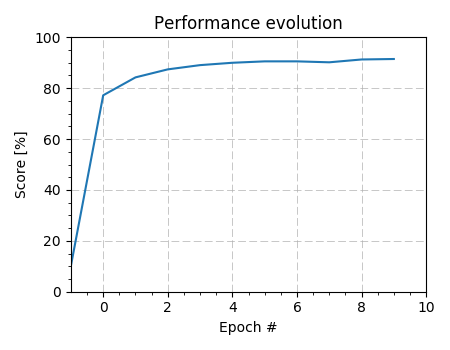

Epoch: 100%|██████████| 10/10 [00:02<00:00,  3.25it/s]


In [3]:
nfts = dset.data.shape[1]  # or len(dset.feature_names) **if available**  # number of features
ncls = len(dset.target_names)  # or len(np.unique(dset.target))  # number of classes
gmin = 1e-8  # Siemens
gmax = 1e-6  # Siemens
gf = 5e5  # scaling factor of the currents in neuron activation function.

# NB: the conductance array is ``2*(nfts + 1)`` row-high because
# each synapse is made of 2 devices, as well as the bias ("+ 1"). 
G = prng.uniform(low=gmin, high=gmax, size=(2*(nfts + 1), ncls))
g = 256 # writable levels

nb_train_steps = len(y_train)
nb_test_steps = len(y_test)
nb_epochs = 10  # how many total cycles we present all train/test sets?

results = np.zeros(nb_epochs + 1)

# Evaluate Model on Test Set before any epoch

correct = 0
for it in range(nb_test_steps):
    xit = X_test[it, :]
    ind = y_test[it]
    currents = compute_currents(xit, G)
    outs = np.tanh(gf * currents)
    if np.argmax(outs) == ind:
        correct += 1
results[0] = (correct / nb_test_steps) * 100

for k in tqdm(range(nb_epochs), desc='Epoch'):

    # Run Model on Train Set

    for it in range(nb_train_steps):

        xit = X_train[it, :]        
        yit = -1.0 * np.ones(G.shape[1])
        yit[y_train[it]] = 1
        
        currents = compute_currents(xit, G)
        outs = np.tanh(gf * currents)

        error = compute_error_v(xit, yit, outs)
        G = gdummynv(G, gmax, gmin, g, nfts, ncls, error)

    # Evaluate Model on Test Set after the current epoch
    #
    # NB: As it is only inference steps, it should be more or less
    # possible to vectorize this loop if speed is an issue.

    correct = 0
    conf_arr = np.zeros((ncls, ncls))  # row is label, col is act
    for it in range(nb_test_steps):
        xit = X_test[it, :]
        ind = y_test[it]
        
        currents = compute_currents(xit, G)
        outs = np.tanh(gf * currents)

        max_index = np.argmax(outs)
        conf_arr[ind, max_index] += 1
        if max_index == ind:
            correct += 1

    results[k + 1] = (correct / nb_test_steps) * 100
    
    # Interactive Plotting
    
    if k == 0:
        # Prepare the figure
        fig_label = "results"
        plt.close(fig_label)
        fig0, ax0 = plt.subplots(num=fig_label, figsize=(4.5, 3.5))
        fig, ax = fig0, ax0  # Copy-pasting is easier if one always use "ax." to call the methods ;).

        # Cosmeticks
        ax.set_title("Performance evolution")
        ax.set_xlabel("Epoch #")
        ax.set_ylabel("Score [%]")
        ax.set_xlim(-1, nb_epochs)
        ax.set_ylim(0, 100)
        ax.minorticks_on()
        ax.grid(ls='dashed', lw=0.5)
        fig.tight_layout()

        # Actual plotting method.
        # Keep a reference to the plotted line to update its data later.
        # Beware that in "line," the comma is not a typo.
        x_ = np.arange(-1, len(results) + 1)
        line, = ax.plot(x_[:k + 2], results[:k + 2])

    elif (k % max(10, int(nb_epochs//25)) == 0) or (k == nb_epochs - 1):
        # Avoid redrawing the whole plot each time
        line.set_data(x_[:k + 2], results[:k + 2])
        fig0.canvas.draw()
        

## Explore the results

<IPython.core.display.Javascript object>


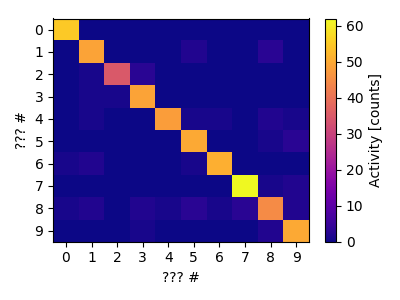

In [4]:
fig1, ax1 = plt.subplots(num="conf_arr", figsize=(4, 3))
fig, ax = fig1, ax1

im1 = ax.imshow(conf_arr, cmap='plasma', aspect='auto', origin='upper')
cb1 = fig.colorbar(im1, ax=ax, label="Activity [counts]")

# Cosmeticks
ax.set_xlabel("??? #")
ax.set_ylabel("??? #")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
fig.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


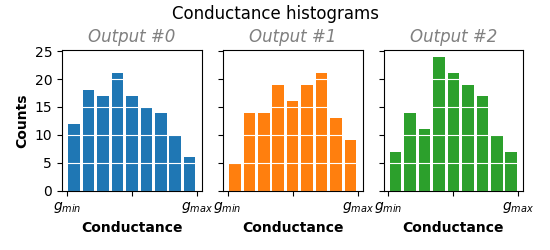

In [5]:
fig2, axs2 = plt.subplots(ncols=3, num="G_hist_1", figsize=(5.5, 2.5), sharex=True,
                          sharey=True)
fig, axs = fig2, axs2

custom_bins = np.linspace(gmin, gmax, 10)
for col, ax in enumerate(axs.flat):
    
    label = f'Output #{col}'  # or 'Output #{0}'.format(col) if Python < 3.6
    color = f'C{col}'  # col-th color of the cycle ('C{0}'.format(col) if Python < 3.6))
    ax.hist(G[:, col], bins=custom_bins, label=label, rwidth=0.8, color=color)

    if ax.is_first_col():
        ax.set_ylabel('Counts', weight='bold')

    if ax.is_first_row():
        ax.set_title(label, color='0.5', style='italic')

    if ax.is_last_row():
        ax.set_xlabel('Conductance', weight='bold')

    ax.set_xticks([gmin, (gmin + gmax)/2, gmax])
    ax.set_xticklabels(['$g_{min}$', '', '$g_{max}$'])
    #ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integers=True))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.grid(axis='y', color='white')  # little aesthetrick :)
    
# Global cosmeticks
fig.tight_layout()
fig.suptitle('Conductance histograms')
fig.subplots_adjust(wspace=0.15, top=0.8)

plt.show()

<IPython.core.display.Javascript object>


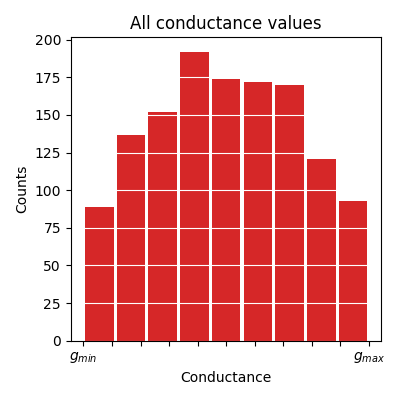

In [6]:
fig3, ax3 = plt.subplots(num="G_hist_2", figsize=(4, 4))
fig, ax = fig3, ax3

custom_bins = np.linspace(gmin, gmax, 10)  # or "auto"?
ax.hist(G.flat, bins=custom_bins, label='Final', rwidth=0.9, color='tab:red')
# NB: 'tab' in 'tab:red' stands for 'Tableau' which is the company that originally
# designed the palette used by Matplotlib 2+.
    
# Cosmeticks

ax.set_ylabel('Counts')
ax.set_title('All conductance values')
ax.set_xlabel('Conductance')

ticks = np.linspace(gmin, gmax, 11)
ax.set_xticks(ticks)
ax.set_xticklabels(['$g_{min}$'] + ['']*(len(ticks) - 2) + ['$g_{max}$'])

#ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integers=True))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid(axis='y', color='white')  # little aesthetrick :)
fig.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


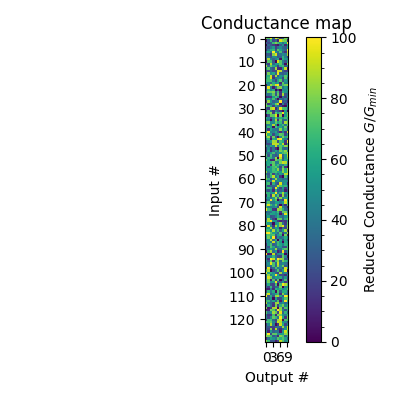

In [9]:
# TODO: switch to a subplot-based layout for the case of MNIST or handwritten digits

fig4, ax4 = plt.subplots(num="G_values", figsize=(4, 4))
fig, ax = fig4, ax4

im4 = ax.imshow(G/gmin, cmap='viridis', aspect='equal', origin='upper',
                vmin=0, vmax=gmax/gmin)
cb4 = fig.colorbar(im4, ax=ax, label="Reduced Conductance $G/G_{min}$")

# Cosmeticks
ax.set_title('Conductance map')
ax.set_xlabel("Output #")
ax.set_ylabel("Input #")
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.yaxis.set_major_locator(MultipleLocator(10))
#cb4.ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Avoid too many major ticks
cb4.ax.minorticks_on()
fig.tight_layout()

plt.show()